In [1]:
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
#from skopt import gp_minimize

In [2]:
import ROOT as rt
import uproot
#from root_numpy import root2array, tree2array
#from root_pandas import read_root
import h5py 

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import numpy as np
import numpy.lib.recfunctions as nlr
import pandas as pd
import os, sys
from matplotlib import pyplot as plt
import math
try:
    import setGPU
except:
    os.environ['KERAS_BACKEND'] = 'tensorflow'
    os.environ['CUDA_VISIBLE_DEVICES'] = '5'

Welcome to JupyROOT 6.22/02
setGPU: Setting GPU to: 0


In [3]:
def samp_to_df(samp_name, total_num):
    dfs = []
    for i in range(total_num+1):
        file_name = f'/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/HHbbggAna/condor/output/{samp_name}{i}.root'
        samp_file = uproot.open(file_name)
        samp_array = samp_file['tree'].arrays()
        samp_df = pd.DataFrame(samp_array)
        dfs.append(samp_df)
    combine_df = pd.concat(dfs, ignore_index=True)
    return combine_df

In [4]:
# Set up dataframes - 2018 (recon == 1)

# Signals
GluGluToHH_df_2018 = samp_to_df('job_5_ntuple20180805v1/GluGluToHHTo2B2G_node_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8Job5ifile', 0)
VBFHH_df_2018 = samp_to_df('job_1_ntuple20180809v2/VBFHHTo2B2G_CV_1_C2V_1_C3_1_TuneCP5_PSWeights_13TeV-madgraph-pythia8Job1ifile', 2)

# Backgrounds
TTGJets_df_2018 = samp_to_df('job_2_ntuple20180805v1/TTGJets_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8Job2ifile', 19)
TTGG_0Jets_df_2018 = samp_to_df('job_3_ntuple20180805v1/TTGG_0Jets_TuneCP5_13TeV_amcatnlo_madspin_pythia8Job3ifile', 28)
TTJets_df_2018 = samp_to_df('job_4_ntuple20180805v1/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8Job4ifile', 304)
VHToGG_df_2018 = samp_to_df('job_6_ntuple20180805v1/VHToGG_M125_13TeV_amcatnloFXFX_madspin_pythia8Job6ifile', 1)
ttHToGG_df_2018 = samp_to_df('job_7_ntuple20180805v1/ttHToGG_M125_TuneCP5_PSweights_13TeV-powheg-pythia8Job7ifile', 2)
VBFHToGG_df_2018 = samp_to_df('job_8_ntuple20180805v1/VBFHToGG_M125_13TeV_amcatnlo_pythia8Job8ifile', 4)
GluGluHToGG_df_2018 = samp_to_df('job_9_ntuple20180805v1/GluGluHToGG_M125_TuneCP5_13TeV-amcatnloFXFX-pythia8Job9ifile', 3)
GJet_SmallPt_df_2018 = samp_to_df('job_10_ntuple20180805v1/GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job10ifile', 15)
GJet_BigPt_df_2018 = samp_to_df('job_11_ntuple20180805v1/GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job11ifile', 10)
DiPhotonJetsBox2B_df_2018 = samp_to_df('job_12_ntuple20180805v1/DiPhotonJetsBox2BJets_MGG-80toInf_13TeV-SherpaJob12ifile', 2)
DiPhotonJetsBox1B_df_2018 = samp_to_df('job_13_ntuple20180805v1/DiPhotonJetsBox1BJet_MGG-80toInf_13TeV-SherpaJob13ifile', 3)
DiPhotonJetsBox_df_2018 = samp_to_df('job_14_ntuple20180805v1/DiPhotonJetsBox_MGG-80toInf_13TeV-SherpaJob14ifile', 23)
QCD_Jets_df_2018 = samp_to_df('job_2_ntuple20180809v2/QCD_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job2ifile', 78)


# Set up dataframes - 2017 (recon == 1)

# Signals
GluGluToHH_df_2017 = samp_to_df('job_8_ntuple20170805v1/GluGluToHHTo2B2G_node_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8Job8ifile', 15)
VBFHH_df_2017 = samp_to_df('job_1_ntuple20170809v2/VBFHHTo2B2G_CV_1_C2V_1_C3_1_13TeV-madgraphJob1ifile', 6)

# Backgrounds
DiPhotonJetsBox1B_df_2017 = samp_to_df('job_2_ntuple20170805v1/DiPhotonJetsBox1BJet_MGG-80toInf_13TeV-SherpaJob2ifile', 15)
DiPhotonJetsBox2B_df_2017 = samp_to_df('job_3_ntuple20170805v1/DiPhotonJetsBox2BJets_MGG-80toInf_13TeV-SherpaJob3ifile', 25)
DiPhotonJetsBox_df_2017 = samp_to_df('job_4_ntuple20170805v1/DiPhotonJetsBox_MGG-80toInf_13TeV-SherpaJob4ifile', 83)
GJet_SmallPt_df_2017 = samp_to_df('job_5_ntuple20170805v1/GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job5ifile', 11)
GJet_BigPt_df_2017 = samp_to_df('job_6_ntuple20170805v1/GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job6ifile', 104)
GluGluHToGG_df_2017 = samp_to_df('job_7_ntuple20170805v1/GluGluHToGG_M-125_13TeV_powheg_pythia8Job7ifile', 1)
TTGG_0Jets_df_2017 = samp_to_df('job_9_ntuple20170805v1/TTGG_0Jets_TuneCP5_13TeV_amcatnlo_madspin_pythia8Job9ifile', 8)
TTGJets_df_2017 = samp_to_df('job_10_ntuple20170805v1/TTGJets_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8Job10ifile', 53)
TTJets_df_2017 = samp_to_df('job_11_ntuple20170805v1/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8Job11ifile', 194)
VBFHToGG_df_2017 = samp_to_df('job_12_ntuple20170805v1/VBFHToGG_M-125_13TeV_powheg_pythia8Job12ifile', 11)
VHToGG_df_2017 = samp_to_df('job_13_ntuple20170805v1/VHToGG_M125_13TeV_amcatnloFXFX_madspin_pythia8Job13ifile', 0)
ttHToGG_df_2017 = samp_to_df('job_14_ntuple20170805v1/ttHToGG_M125_13TeV_powheg_pythia8Job14ifile', 3)
QCD_Jets_df_2017 = samp_to_df('job_2_ntuple20180809v2/QCD_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job2ifile', 18)


# Set up dataframes - 2016 (recon == 1)

# Signals
GluGluToHH_df_2016 = samp_to_df('job_8_ntuple20160805v1/GluGluToHHTo2B2G_node_cHHH1_TuneCUETP8M1_PSWeights_13TeV-powheg-pythia8Job8ifile', 3)
VBFHH_df_2016 = samp_to_df('job_1_ntuple20160809v2/VBFHHTo2B2G_CV_1_C2V_1_C3_1_13TeV-madgraphJob1ifile', 0)

# Background
DiPhotonJetsBox1B_df_2016 = samp_to_df('job_2_ntuple20160805v1/DiPhotonJetsBox1BJet_MGG-80toInf_TuneSherpa_13TeV-SherpaJob2ifile', 17)
DiPhotonJetsBox2B_df_2016 = samp_to_df('job_3_ntuple20160805v1/DiPhotonJetsBox2BJets_MGG-80toInf_TuneSherpa_13TeV-SherpaJob3ifile', 23)
DiPhotonJetsBox_df_2016 = samp_to_df('job_4_ntuple20160805v1/DiPhotonJetsBox_MGG-80toInf_13TeV-SherpaJob4ifile', 48)
GJet_SmallPt_df_2016 = samp_to_df('job_5_ntuple20160805v1/GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8Job5ifile', 13)
GJet_BigPt_df_2016 = samp_to_df('job_6_ntuple20160805v1/GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8Job6ifile', 64)
GluGluHToGG_df_2016 = samp_to_df('job_7_ntuple20160805v1/GluGluHToGG_M125_13TeV_amcatnloFXFX_pythiaJob7ifile', 0)
TTGG_0Jets_df_2016 = samp_to_df('job_9_ntuple20160805v1/TTGG_0Jets_TuneCUETP8M1_13TeV_amcatnlo_madspin_pythia8Job9ifile', 2)
TTGJets_df_2016 = samp_to_df('job_10_ntuple20160805v1/TTGJets_TuneCUETP8M1_13TeV-amcatnloFXFX-madspin-pythia8Job10ifile', 12)
TTJets_df_2016 = samp_to_df('job_11_ntuple20160805v1/TTJets_TuneCUETP8M2T4_13TeV-amcatnloFXFX-pythia8Job11ifile', 43)
VBFHToGG_df_2016 = samp_to_df('job_12_ntuple20160805v1/VBFHToGG_M125_13TeV_amcatnlo_pythia8_v2Job12ifile', 11)
VHToGG_df_2016 = samp_to_df('job_13_ntuple20160805v1/VHToGG_M125_13TeV_amcatnloFXFX_madspin_pythia8Job13ifile', 1)
ttHToGG_df_2016 = samp_to_df('job_14_ntuple20160805v1/ttHToGG_M125_13TeV_powheg_pythia8_v2Job14ifile', 0)
QCD_Jets_df_2016 = samp_to_df('job_2_ntuple20160809v2/QCD_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8Job2ifile', 15)


# Combine by sample (recon == 1)

# Signals 
GluGluToHH_df = pd.concat([GluGluToHH_df_2018, GluGluToHH_df_2017, GluGluToHH_df_2016], ignore_index=True)
VBFHH_df = pd.concat([VBFHH_df_2018, VBFHH_df_2017, VBFHH_df_2016], ignore_index=True)

# Backgrounds
TTGJets_df = pd.concat([TTGJets_df_2018, TTGJets_df_2017, TTGJets_df_2016], ignore_index=True)
TTGG_0Jets_df = pd.concat([TTGG_0Jets_df_2018, TTGG_0Jets_df_2017, TTGG_0Jets_df_2016], ignore_index=True)
TTJets_df = pd.concat([TTJets_df_2018, TTJets_df_2017, TTJets_df_2016], ignore_index=True)
VHToGG_df = pd.concat([VHToGG_df_2018, VHToGG_df_2017, VHToGG_df_2016], ignore_index=True)
ttHToGG_df = pd.concat([ttHToGG_df_2018, ttHToGG_df_2017, ttHToGG_df_2016], ignore_index=True)
VBFHToGG_df = pd.concat([VBFHToGG_df_2018, VBFHToGG_df_2017, VBFHToGG_df_2016], ignore_index=True)
GluGluHToGG_df = pd.concat([GluGluHToGG_df_2018, GluGluHToGG_df_2017, GluGluHToGG_df_2016], ignore_index=True)
GJet_SmallPt_df = pd.concat([GJet_SmallPt_df_2018, GJet_SmallPt_df_2017, GJet_SmallPt_df_2016], ignore_index=True)
GJet_BigPt_df = pd.concat([GJet_BigPt_df_2018, GJet_BigPt_df_2017, GJet_BigPt_df_2016], ignore_index=True)
DiPhotonJetsBox2B_df = pd.concat([DiPhotonJetsBox2B_df_2018, DiPhotonJetsBox2B_df_2017, DiPhotonJetsBox2B_df_2016], ignore_index=True)
DiPhotonJetsBox1B_df = pd.concat([DiPhotonJetsBox1B_df_2018, DiPhotonJetsBox1B_df_2017, DiPhotonJetsBox1B_df_2016], ignore_index=True)
DiPhotonJetsBox_df = pd.concat([DiPhotonJetsBox_df_2018, DiPhotonJetsBox_df_2017, DiPhotonJetsBox_df_2016], ignore_index=True)
QCD_Jets_df = pd.concat([QCD_Jets_df_2018, QCD_Jets_df_2017, QCD_Jets_df_2016], ignore_index=True)

In [5]:
training_vars = [b'leading_photon_pt', b'leading_photon_eta', b'leading_photon_phi', 
                 b'subleading_photon_pt', b'subleading_photon_eta', b'subleading_photon_phi',
                 b'leading_bjet_pt', b'leading_bjet_eta', b'leading_bjet_phi',
                 b'subleading_bjet_pt', b'subleading_bjet_eta', b'subleading_bjet_phi',
                 b'leadingDeepBscore', b'subleadingDeepBscore', b'sumDeepBscore',
                 b'leading_pho_pt_over_dimass', b'leading_bjet_pt_over_dimass', b'leading_bjet_pt_over_dimass_corr'
                ]

aug_vars = [b'dibjet_mass', b'diphoton_mass', b'event']

w_var = [b'genweight']

In [19]:
path = '/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/HHbbggAna/condor/output/'

BKD_dfs = [TTGJets_df, TTGG_0Jets_df, TTJets_df, VHToGG_df, ttHToGG_df, VBFHToGG_df, GluGluHToGG_df,
            GJet_SmallPt_df, GJet_BigPt_df, DiPhotonJetsBox2B_df, DiPhotonJetsBox1B_df, DiPhotonJetsBox_df, QCD_Jets_df]

names = ['TTG Jets', 'TTGG_0Jets', 'TTJets', 'VHToGG', 'ttHToGG', 'VBFHToGG', 'GluGluHToGG',
         'GJet_SmallPt', 'GJet_BigPt', 'DiPhotonJetsBox2B', 'DiPhotonJetsBox1B', 'DiPhotonJetsBox', 'QCD_Jets']
i = 1 # select sample

sig_frame_all = GluGluToHH_df
bkg_frame_all = BKD_dfs[i]

#print(sig_frame_all.iloc[:1])

#select events with cuts
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html

sig_frame = sig_frame_all[sig_frame_all[b'leading_photon_pt'] > 0][sig_frame_all[b'leading_bjet_pt'] > 0][training_vars]
bkg_frame = bkg_frame_all[bkg_frame_all[b'leading_photon_pt'] > 0][bkg_frame_all[b'leading_bjet_pt'] > 0][training_vars]


sig_df = sig_frame_all[sig_frame_all[b'leading_photon_pt'] > 0][sig_frame_all[b'leading_bjet_pt'] > 0][training_vars + w_var + aug_vars]
bkg_df = bkg_frame_all[bkg_frame_all[b'leading_photon_pt'] > 0][bkg_frame_all[b'leading_bjet_pt'] > 0][training_vars + w_var + aug_vars]

sig_weight = sig_frame_all[sig_frame_all[b'leading_photon_pt'] > 0][sig_frame_all[b'leading_bjet_pt'] > 0][w_var]
bkg_weight = bkg_frame_all[bkg_frame_all[b'leading_photon_pt'] > 0][bkg_frame_all[b'leading_bjet_pt'] > 0][w_var]

#print(sig_frame[training_vars].head(), bkg_frame[training_vars].head())
#print(sig_frame.head(), bkg_frame.head())

In [20]:
sig_df.head()

,b'leading_photon_pt',b'leading_photon_eta',b'leading_photon_phi',b'subleading_photon_pt',b'subleading_photon_eta',b'subleading_photon_phi',b'leading_bjet_pt',b'leading_bjet_eta',b'leading_bjet_phi',b'subleading_bjet_pt',...,b'leadingDeepBscore',b'subleadingDeepBscore',b'sumDeepBscore',b'leading_pho_pt_over_dimass',b'leading_bjet_pt_over_dimass',b'leading_bjet_pt_over_dimass_corr',b'genweight',b'dibjet_mass',b'diphoton_mass',b'event'
0,145.241119,0.918335,0.491089,75.707062,0.319824,1.547607,142.2500,2.209473,-2.042480,28.140625,...,0.074707,0.050354,0.125061,1.176838,0.753909,0.984135,0.000028,188.683197,123.416451,112008
1,81.548317,-0.114059,2.528809,68.587204,-0.079712,0.564209,80.1250,-1.288086,-0.381775,60.750000,...,0.039551,0.964844,1.004395,0.655325,0.715544,0.747966,-0.000028,111.977684,124.439453,112017
2,109.037231,-0.835327,1.176514,87.997322,-0.765747,2.546875,115.9375,-1.357910,-1.699951,69.312500,...,0.331299,0.424072,0.755371,0.878197,1.041834,1.011527,0.000028,111.282120,124.160385,112010
3,99.698898,-0.390930,-0.474426,54.716755,-0.526611,1.511963,92.5625,0.323792,2.379883,26.750000,...,0.189087,0.656250,0.845337,0.802983,0.870629,0.821134,0.000028,106.316811,124.160637,112001
4,78.673645,2.106934,-1.360596,74.914726,1.376465,0.152924,178.5000,1.395996,2.549316,31.062500,...,0.998047,0.077209,1.075256,0.655613,1.426055,1.441129,0.000028,125.170486,120.000145,112006


In [21]:
bkg_df.head()

,b'leading_photon_pt',b'leading_photon_eta',b'leading_photon_phi',b'subleading_photon_pt',b'subleading_photon_eta',b'subleading_photon_phi',b'leading_bjet_pt',b'leading_bjet_eta',b'leading_bjet_phi',b'subleading_bjet_pt',...,b'leadingDeepBscore',b'subleadingDeepBscore',b'sumDeepBscore',b'leading_pho_pt_over_dimass',b'leading_bjet_pt_over_dimass',b'leading_bjet_pt_over_dimass_corr',b'genweight',b'dibjet_mass',b'diphoton_mass',b'event'
0,132.955734,-0.310791,-0.537842,43.647694,0.034973,1.554443,34.40625,0.312683,-2.142578,29.296875,...,0.205322,0.125000,0.330322,0.988549,0.494141,0.529404,0.000616,69.628349,134.495880,36006
1,149.032623,-0.846191,-0.561401,51.304478,-2.003418,1.150391,152.87500,-1.380859,2.586914,135.125000,...,0.231567,0.990234,1.221802,0.877036,1.015032,1.036644,0.000616,150.611008,169.927551,36013
2,212.244278,2.106934,-0.577881,72.232155,2.030762,0.263794,90.37500,0.530029,0.937988,31.734375,...,0.957031,0.291016,1.248047,2.088931,0.861275,0.892128,0.000616,104.931602,101.604263,36034
3,81.501740,-1.124023,0.507690,32.953495,0.673096,1.693604,69.18750,-1.746826,-2.346680,30.000000,...,0.806641,0.022461,0.829102,0.568063,0.552645,0.614313,0.000616,125.193336,143.473099,36044
4,47.950096,0.237091,-0.073486,29.699394,-1.785400,2.641113,57.03125,0.485718,-2.955078,31.359375,...,0.287354,0.962402,1.249756,0.412034,0.577280,0.647920,0.000616,98.793037,116.374062,36104


In [22]:
#bkg_frame.head()
# Standardize
x_mean = bkg_frame.mean()
x_std = bkg_frame.std()

sig_frame = (sig_frame-x_mean)/x_std
bkg_frame = (bkg_frame-x_mean)/x_std
signal = sig_frame.values
background = bkg_frame.values
#print signal, background
signal_all = sig_df.values
background_all = bkg_df.values

# Shuffle before splitting into train-val
randix = np.arange(len(background))
np.random.shuffle(randix)
#np.random.shuffle(background)
#np.random.shuffle(signal)

randix2 = np.arange(len(signal))
np.random.shuffle(randix2)
signal_ = signal[randix2]
signal_all_=signal_all[randix2]
#signal_ = signal_[:len(background)]

background_ = background[randix]
background_all_ = background_all[randix]
#background_ = background_[:len(signal)] # downsampling

sig_label = np.ones(len(signal_))
bkg_label = np.zeros(len(background_))

data = np.concatenate((signal_,background_))
label = np.concatenate((sig_label,bkg_label))
data_all = np.concatenate((signal_all_,background_all_))

sig_weight_np = sig_weight.values
bkg_weight_np = bkg_weight.values
sig_weight_np_sfl = sig_weight_np[randix2]
bkg_weight_np_sfl = bkg_weight_np[randix]
weights = np.concatenate((sig_weight_np_sfl, bkg_weight_np_sfl))

skf = StratifiedKFold(n_splits=5, shuffle=True)
skf.get_n_splits(data, label)
print(skf)

StratifiedKFold(n_splits=5, random_state=None, shuffle=True)


In [40]:
# full df prep
print(sig_frame_all.head())
sig_frame_full = sig_frame_all.values
print(sig_frame_full)
sig_frame_full = sig_frame_full[randix2]
bgd_frame_full = bkg_frame_all.values
bgd_frame_full=bgd_frame_full[randix]
data_full = np.concatenate((sig_frame_full, bgd_frame_full))
print(data_full)

   b'run'  b'lumi'  b'event'  b'trig_decision'  b'pv_pass'  \
0       1     1121    112008                 1           1   
1       1     1121    112017                 1           1   
2       1     1121    112010                 1           1   
3       1     1121    112001                 1           1   
4       1     1121    112006                 1           1   

   b'leading_photon_pt'  b'leading_photon_eta'  b'leading_photon_phi'  \
0            145.241119               0.918335               0.491089   
1             81.548317              -0.114059               2.528809   
2            109.037231              -0.835327               1.176514   
3             99.698898              -0.390930              -0.474426   
4             78.673645               2.106934              -1.360596   

   b'subleading_photon_pt'  b'subleading_photon_eta'  ...  \
0                75.707062                  0.319824  ...   
1                68.587204                 -0.079712  ...   
2    

In [41]:
for train_index, test_index in skf.split(data, label):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = data[train_index], data[test_index]
    y_train, y_test = label[train_index], label[test_index]
    train_weight, test_weight = weights[train_index], weights[test_index]
    x_all_test = data_all[test_index]
    x_full_test = data_full[test_index] # full df test portion

TRAIN: [     0      1      2 ... 327211 327212 327213] TEST: [     7     11     18 ... 327203 327207 327209]
TRAIN: [     0      1      3 ... 327211 327212 327213] TEST: [     2     10     12 ... 327205 327208 327210]
TRAIN: [     0      2      7 ... 327209 327210 327211] TEST: [     1      3      4 ... 327206 327212 327213]
TRAIN: [     0      1      2 ... 327211 327212 327213] TEST: [     8      9     16 ... 327193 327194 327195]
TRAIN: [     1      2      3 ... 327210 327212 327213] TEST: [     0     14     22 ... 327201 327204 327211]


In [42]:
print (x_train.shape)
print (y_train.shape)
print (x_test.shape)
print (y_test.shape)
model = Sequential()
model.add(Dense(100, input_dim=len(training_vars),activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

(261772, 18)
(261772,)
(65442, 18)
(65442,)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 100)               1900      
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                6464      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (

In [17]:
print(x_train)
print(y_train)

[[ 2.8342478   0.12669992 -0.34324813 ...  2.756643    0.4303269
  -0.27333766]
 [ 0.5125748   0.7489757  -0.5504177  ...  0.47988257  0.74309695
   0.7840227 ]
 [-0.25577712 -0.28120282  1.2418354  ... -0.27361357 -0.35186115
  -0.42606384]
 ...
 [ 0.01423734  0.4221304   0.30444363 ...  0.05531248 -0.1731524
  -0.1434847 ]
 [-0.49131688  1.9077018  -0.67370725 ... -0.5017712  -0.16799723
  -0.12899037]
 [-0.55548054 -0.76209813 -0.50945616 ... -0.5323374  -0.07089046
   0.08505392]]
[1. 1. 1. ... 0. 0. 0.]


In [12]:
#print X_train, y_train
#print X_val, y_val
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [43]:
#https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
hist = model.fit(x_train, y_train, batch_size=150, epochs=50,verbose=1,validation_split=0.2,
                  callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min'),
                            ModelCheckpoint(filepath='Models/2018/'+names[i]+'_2018_mass_model.h5', verbose=0)])
                 #lass_weight={0:10,1:1})

Epoch 1/50
1397/1397 [==============================] - 3s 2ms/step - loss: 0.5098 - accuracy: 0.7470 - val_loss: 0.4836 - val_accuracy: 0.7755
Epoch 2/50
1397/1397 [==============================] - 3s 2ms/step - loss: 0.4069 - accuracy: 0.8195 - val_loss: 0.3722 - val_accuracy: 0.8398
Epoch 3/50
1397/1397 [==============================] - 3s 2ms/step - loss: 0.3348 - accuracy: 0.8624 - val_loss: 0.2955 - val_accuracy: 0.8863
Epoch 4/50
1397/1397 [==============================] - 3s 2ms/step - loss: 0.2830 - accuracy: 0.8919 - val_loss: 0.2724 - val_accuracy: 0.8991
Epoch 5/50
1397/1397 [==============================] - 3s 2ms/step - loss: 0.2682 - accuracy: 0.8996 - val_loss: 0.2525 - val_accuracy: 0.9036
Epoch 6/50
1397/1397 [==============================] - 3s 2ms/step - loss: 0.2620 - accuracy: 0.9017 - val_loss: 0.2391 - val_accuracy: 0.9086
Epoch 7/50
1397/1397 [==============================] - 3s 2ms/step - loss: 0.2581 - accuracy: 0.9039 - val_loss: 0.2611 - val_accuracy:

In [14]:
def show_losses( histories ):
    plt.figure(figsize=(10,10))
    #plt.ylim(bottom=0)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Error by Epoch')
    colors=[]
    do_acc=False
    for label,loss in histories:
        color = tuple(np.random.random(3))
        colors.append(color)
        l = label
        vl= label+" validation"
        if 'acc' in loss.history:
            l+=' (acc %2.4f)'% (loss.history['acc'][-1])
            do_acc = True
        if 'val_acc' in loss.history:
            vl+=' (val acc %2.4f)'% (loss.history['val_acc'][-1])
            do_acc = True
        plt.plot(loss.history['loss'], label=l, color=color)
        if 'val_loss' in loss.history:
            plt.plot(loss.history['val_loss'], lw=2, ls='dashed', label=vl, color=color)


    plt.legend()
    #plt.yscale('log')
    plt.show()
    if not do_acc: return
    plt.figure(figsize=(10,10))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    for i,(label,loss) in enumerate(histories):
        color = colors[i]
        if 'acc' in loss.history:
            plt.plot(loss.history['acc'], lw=2, label=label+" accuracy", color=color)
        if 'val_acc' in loss.history:
            plt.plot(loss.history['val_acc'], lw=2, ls='dashed', label=label+" validation accuracy", color=color)
    plt.legend(loc='lower right')
    plt.show()

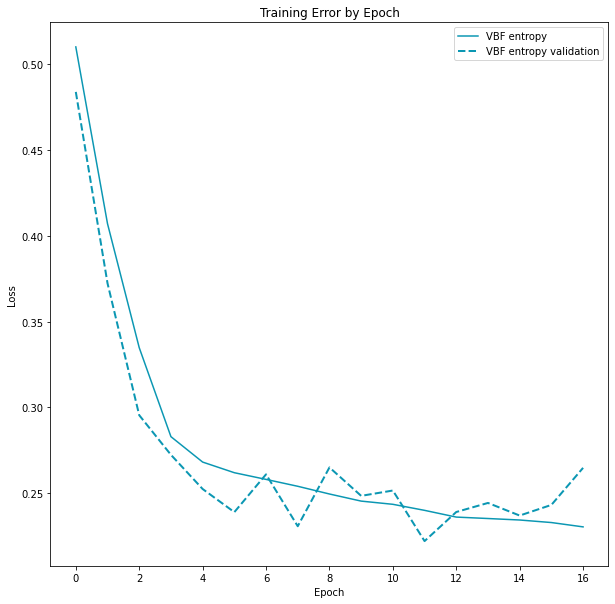

In [44]:
show_losses( [("VBF entropy", hist)])

In [45]:
from sklearn.metrics import roc_curve
y_pred2 = model.predict(x_test)
y_pred = y_pred2.ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)

In [46]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

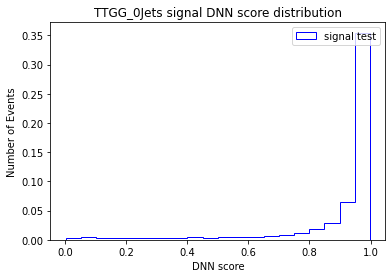

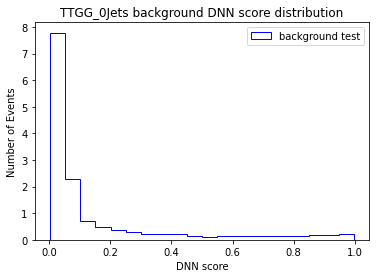

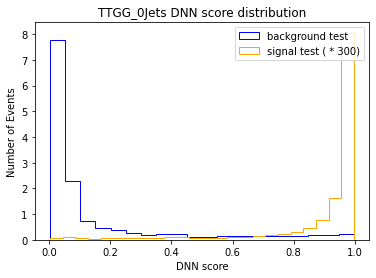

In [47]:
# Plot DNN score distribution

bgd = y_pred[y_test == 0]
sgl = y_pred[y_test == 1]
sgl_weight = test_weight[y_test == 1].flatten()
bgd_weight = test_weight[y_test == 0].flatten()

plt.hist(sgl, color='blue', weights= sgl_weight, histtype='step', bins = 20, label= 'signal test')
plt.xlabel('DNN score')
plt.ylabel('Number of Events')
#plt.vlines(0.55, ymin=0, ymax = 0.10, color = 'orange')
plt.legend(loc = 'best')
plt.title(names[i] + ' signal DNN score distribution')
plt.savefig(fname = f'DNN_Score_Plts/2018/{names[i]}_2018_mass_sig_score.png', format='png')
plt.show()

plt.hist(bgd, color='blue', weights= bgd_weight, histtype='step', bins = 20, label= 'background test')
plt.xlabel('DNN score')
plt.ylabel('Number of Events')
#plt.vlines(0.5, ymin=0, ymax = 10, color = 'orange')
plt.legend(loc = 'best')
plt.title(names[i] + ' background DNN score distribution')
plt.savefig(fname = f'DNN_Score_Plts/2018/{names[i]}_2018_mass_bkg_score.png', format='png')
plt.show()

plt.hist(bgd, color='blue', weights= bgd_weight, histtype='step', bins = 20, label= 'background test')
plt.hist(sgl, color='orange', weights= 24 * sgl_weight, histtype='step', bins = 24, label= 'signal test ( * 300)')
plt.xlabel('DNN score')
plt.ylabel('Number of Events')
plt.legend(loc = 'best')
plt.title(names[i] + ' DNN score distribution')
plt.savefig(fname = f'DNN_Score_Plts/2018/{names[i]}_2018_mass_score.png', format='png')
plt.show()

In [48]:
bgd_x_all = x_all_test[y_test == 0]
bgd_y = y_pred[y_test == 0]
bgd_test = y_test[y_test == 0]
print(bgd_x_all.shape)
print(bgd_y.shape)

sig_x_all = x_all_test[y_test == 1]
sig_y = y_pred[y_test == 1]
sig_test = y_test[y_test == 1]

result_sig_df = pd.DataFrame(sig_x_all, columns = list(sig_df.columns))
result_sig_df[b'DNN score'] = sig_y
result_bgd_df = pd.DataFrame(bgd_x_all, columns = list(bkg_df.columns))
result_bgd_df[b'DNN score'] = bgd_y

(36722, 22)
(36722,)


In [49]:
result_sig_df.head()

,b'leading_photon_pt',b'leading_photon_eta',b'leading_photon_phi',b'subleading_photon_pt',b'subleading_photon_eta',b'subleading_photon_phi',b'leading_bjet_pt',b'leading_bjet_eta',b'leading_bjet_phi',b'subleading_bjet_pt',...,b'subleadingDeepBscore',b'sumDeepBscore',b'leading_pho_pt_over_dimass',b'leading_bjet_pt_over_dimass',b'leading_bjet_pt_over_dimass_corr',b'genweight',b'dibjet_mass',b'diphoton_mass',b'event',b'DNN score'
0,128.533661,-1.186523,1.237549,76.150833,-0.586792,0.091034,98.0000,0.844604,-2.529785,35.34375,...,0.048523,0.965027,1.044456,1.200923,0.930391,0.000028,81.603882,123.062836,90196.0,0.984297
1,106.177841,1.040771,-2.773926,37.414089,-0.480469,-1.602783,86.9375,-1.434082,0.302490,33.65625,...,0.022888,1.014587,0.840401,0.821986,0.709986,0.000028,105.765129,126.341820,105898.0,0.985115
2,111.988525,1.853027,0.740967,57.601406,1.356934,-1.004639,77.0625,1.238525,-1.537598,73.62500,...,0.869141,1.718262,0.864896,0.686346,0.682422,0.000019,112.279411,129.482071,182988.0,0.857307
3,123.486298,-0.146515,1.988037,61.018745,-0.006042,-2.706543,46.1250,1.400391,-1.396484,36.53125,...,0.940918,1.812500,0.992274,1.513349,0.672376,-0.000016,30.478764,124.447784,60816.0,0.923520
4,126.141388,-1.095459,-2.465820,48.437820,0.165588,2.957031,153.2500,0.289490,0.586426,25.37500,...,0.024857,1.023392,1.018975,1.412310,1.391474,0.000019,108.510178,123.792366,33848.0,0.990843


In [50]:
result_bgd_df.head()

,b'leading_photon_pt',b'leading_photon_eta',b'leading_photon_phi',b'subleading_photon_pt',b'subleading_photon_eta',b'subleading_photon_phi',b'leading_bjet_pt',b'leading_bjet_eta',b'leading_bjet_phi',b'subleading_bjet_pt',...,b'subleadingDeepBscore',b'sumDeepBscore',b'leading_pho_pt_over_dimass',b'leading_bjet_pt_over_dimass',b'leading_bjet_pt_over_dimass_corr',b'genweight',b'dibjet_mass',b'diphoton_mass',b'event',b'DNN score'
0,75.462074,1.743896,-1.729492,34.606789,1.201904,0.849121,74.5000,1.852783,1.764893,51.03125,...,0.392334,1.294189,0.739042,0.760449,0.703367,0.000616,97.968460,102.107956,1493354.0,0.032217
1,36.561958,-2.263184,-0.732788,28.993006,0.431702,1.785645,70.5000,-0.128937,-2.583008,50.65625,...,0.813965,1.148682,0.358444,0.624220,0.612664,0.000853,112.940941,102.001884,187666.0,0.011661
2,70.776405,1.610107,1.650635,35.762409,0.196686,-0.747314,64.3750,2.040039,3.125977,43.68750,...,0.023788,0.946640,0.582869,0.474988,0.669684,-0.000616,135.529739,121.427605,1312146.0,0.360230
3,58.622986,-0.214630,-1.578369,53.767807,0.847656,2.109375,72.8750,-0.917969,-1.168701,35.50000,...,0.963379,1.090942,0.469430,0.554584,0.445069,0.000616,131.404907,124.881149,1439918.0,0.544632
4,100.252701,-0.877075,-1.950195,39.693798,-1.731689,1.449951,76.4375,-0.302673,-1.081299,56.65625,...,0.999512,1.657715,0.732322,0.324303,0.642731,0.000783,235.697723,136.896973,467054.0,0.023480


In [54]:
from ROOT import RDF
from ROOT import Internal

result_sig_dict = {key.decode("utf-8"): result_sig_df[key].values for key in list(result_sig_df.columns)}
result_bgd_dict = {key.decode("utf-8"): result_bgd_df[key].values for key in list(result_bgd_df.columns)}
sig_rdf = rt.RDF.MakeNumpyDataFrame(result_sig_dict)
bgd_rdf = rt.RDF.MakeNumpyDataFrame(result_bgd_dict)

In [57]:
sig_rdf.Snapshot('tree', f'DNN_Trees/2018/{names[i]}_sig_DNN_file.root')
bgd_rdf.Snapshot('tree', f'DNN_Trees/2018/{names[i]}_bgd_DNN_file.root')

<cppyy.gbl.ROOT.RDF.RResultPtr<ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void> > object at 0x59fd7d10>

In [58]:
# Bkg reduction
# Bkg reduction
def significance_file(k):
    file.write(f'cutoff: {k}\n')
    bgd = y_pred[y_test == 0]
    file.write(f'# background: {len(bgd)}\n')
    bgd_bin = []
    for event in bgd:
        if event >= k:
            bgd_bin.append(1)
        else:
            bgd_bin.append(0)
    file.write(f'# false signal: {sum(bgd_bin)}\n')

    sgl = y_pred[y_test == 1]
    file.write(f'# signal: {len(sgl)}\n')
    sgl_bin = []
    for event in sgl:
        if event >= k:
            sgl_bin.append(1)
        else:
            sgl_bin.append(0)
    file.write(f'# true signal: {sum(sgl_bin)}\n')
    bgd_bin_np = np.array(bgd_bin)
    sgl_bin_np = np.array(sgl_bin)
    sgl_weight = test_weight[y_test == 1].flatten()
    bgd_weight = test_weight[y_test == 0].flatten()
    file.write(f'original background: {np.sum(bkg_weight_np_sfl)}\n')
    file.write(f'original test background: {np.sum(bgd_weight)}\n')
    file.write(f'original signal: {np.sum(sig_weight_np_sfl)}\n')
    file.write(f'original test signal: {np.sum(sgl_weight)}\n')

    re_bkg = np.sum(bgd_bin_np * bgd_weight)
    file.write(f'remaining background: {re_bkg}\n')
    re_sig = np.sum(sgl_bin_np * sgl_weight)
    file.write(f'remaining signal: {re_sig}\n')
    file.write(f'original S/sqrt(S+B): {np.sum(sig_weight_np_sfl) / np.sqrt(np.sum(sig_weight_np_sfl) + np.sum(bkg_weight_np_sfl))}\n')
    file.write(f'original test S/sqrt(S+B): {np.sum(sgl_weight) / np.sqrt(np.sum(sgl_weight) + np.sum(bgd_weight))}\n')
    file.write(f'S/sqrt(S+B): {re_sig / np.sqrt(re_sig + re_bkg)}\n')
    file.write('\n')
    return re_sig / np.sqrt(re_sig + re_bkg)

def significance_print(k):
    print(f'cutoff: {k}')
    bgd = y_pred[y_test == 0]
    print(f'# background: {len(bgd)}\n')
    bgd_bin = []
    for event in bgd:
        if event >= k:
            bgd_bin.append(1)
        else:
            bgd_bin.append(0)
    print(f'# false signal: {sum(bgd_bin)}\n')

    bgd = y_pred[y_test == 0]
    print(f'# signal: {len(sgl)}')
    sgl_bin = []
    for event in sgl:
        if event >= k:
            sgl_bin.append(1)
        else:
            sgl_bin.append(0)
    print(f'# true signal: {sum(sgl_bin)}\n')
    bgd_bin_np = np.array(bgd_bin)
    sgl_bin_np = np.array(sgl_bin)
    sgl_weight = test_weight[y_test == 1].flatten()
    bgd_weight = test_weight[y_test == 0].flatten()
    print(f'original background: {np.sum(bkg_weight_np_sfl)}')
    print(f'original test background: {np.sum(bgd_weight)}')
    print(f'original signal: {np.sum(sig_weight_np_sfl)}')
    print(f'original test signal: {np.sum(sgl_weight)}')

    re_bkg = np.sum(bgd_bin_np * bgd_weight)
    print(f'remaining background: {re_bkg}\n')
    re_sig = np.sum(sgl_bin_np * sgl_weight)
    print(f'remaining signal: {re_sig}\n')
    print(f'original S/sqrt(S+B): {np.sum(sig_weight_np_sfl) / np.sqrt(np.sum(sig_weight_np_sfl) + np.sum(bkg_weight_np_sfl))}\n')
    print(f'original test S/sqrt(S+B): {np.sum(sgl_weight) / np.sqrt(np.sum(sgl_weight) + np.sum(bgd_weight))}\n')
    print(f'S/sqrt(S+B): {re_sig / np.sqrt(re_sig + re_bkg)}\n')
    print('\n')
    return re_sig / np.sqrt(re_sig + re_bkg)

In [215]:
# GJet small pt
print('GJet Small Pt')
significance_print(0.99967)

GJet Small Pt
cutoff: 0.99967
# background: 166

# false signal: 1

# signal: 9638
# true signal: 9353

original background: 4031.71728515625
original test background: 807.3160400390625
original signal: 5.967202663421631
original test signal: 1.1972697973251343
remaining background: 4.863349914550781

remaining signal: 1.1581250134040602

original S/sqrt(S+B): 0.09390842914581299

original test S/sqrt(S+B): 0.04210643097758293

S/sqrt(S+B): 0.4719587046622544





0.4719587046622544

In [236]:
# GJet big pt
print('GJet Big Pt')
significance_print(0.99985)

GJet Big Pt
cutoff: 0.99985
# background: 1222

# false signal: 56

# signal: 9638
# true signal: 8085

original background: 157688.375
original test background: 31542.837890625
original signal: 5.967202663421631
original test signal: 1.1867735385894775
remaining background: 1445.498291015625

remaining signal: 0.9824084098363528

original S/sqrt(S+B): 0.015026669017970562

original test S/sqrt(S+B): 0.006682043429464102

S/sqrt(S+B): 0.02583067468996548





0.02583067468996548

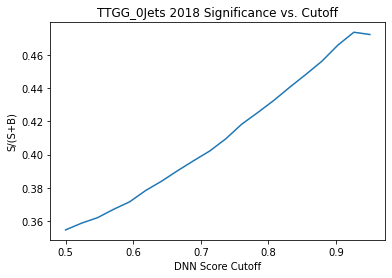

In [59]:
test_sc = np.linspace(0.5, 0.95, 20)
sc_vals = []
file = open('DNN_Score_Nums/2018/' + names[i]+'_2018_mass_DNN_score.txt', "w")
for value in test_sc:
    sc_vals.append(significance_file(value))

file.close()
    
plt.plot(test_sc, sc_vals, label = names[i])
plt.xlabel('DNN Score Cutoff')
plt.ylabel('S/(S+B)')
plt.title(names[i] + ' 2018 Significance vs. Cutoff')
plt.savefig(fname = f'DNN_Score_Plts/2018/{names[i]}_2018_mass_significance', format='png')
plt.show()

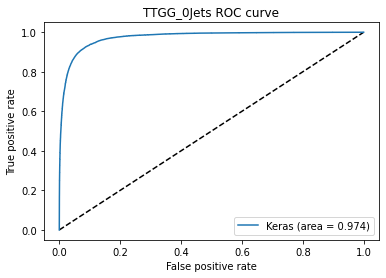

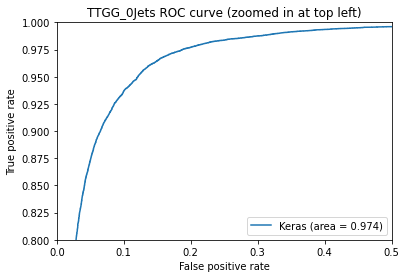

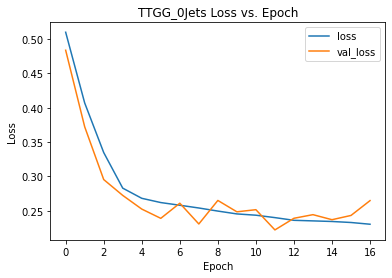

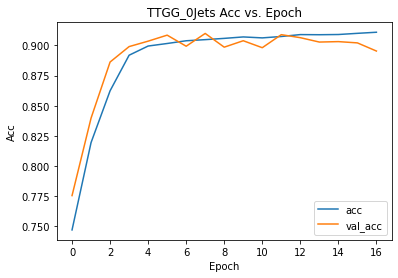

In [60]:
# Plots

# ROC curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title(names[i] + ' ROC curve')
plt.legend(loc='best')
plt.savefig(fname = f'ROC_Plts/2018/{names[i]}_mass_ROC_curve.png', format='png')
plt.show()

# Zoom in view of the upper left corner ROC curve
plt.figure(2)
plt.xlim(0, 0.5)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label= 'Keras (area = {:.3f})'.format(auc_keras))
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(names[i] + ' ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig(fname = f'ROC_Plts/2018/{names[i]}_mass_ROC_curve_zoom')
plt.show()


# plot loss vs epoch
plt.figure(3)
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(loc="best")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(names[i] + ' Loss vs. Epoch')
plt.savefig(fname = f'Epoch_Plts/2018/{names[i]}_mass_loss_epoch.png', format='png')
plt.show()

# plot accuracy vs epoch
plt.figure(4)
plt.plot(hist.history['accuracy'], label='acc')
plt.plot(hist.history['val_accuracy'], label='val_acc')
plt.legend(loc="best")
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title(names[i] + ' Acc vs. Epoch')
plt.savefig(fname = f'Epoch_Plts/2018/{names[i]}_mass_acc_epoch.png', format='png')
plt.show()

In [61]:
file = open('Efficiency/2018/' + names[i]+'_2018_mass_DNN_efficiency.txt', "w")
file.write('1% acceptance\n')
for x in tpr_keras[fpr_keras>=0.009997]:
    if x in tpr_keras[fpr_keras<=0.01]:
        file.write(f'{x}\n')

file.write('\n')

file.write('0.1% acceptance\n')
for y in tpr_keras[fpr_keras>=0.0009997]:
    if y in tpr_keras[fpr_keras<=0.001]:
        file.write(f'{y}\n')
file.close()

In [62]:
def check_mass_gg(label, test_all, var_index, weight_index, dnn_index, label_index, samp):
    samples = ['Background', 'Signal']
    fontsize=25
    TPR_thresholds = [0.8,0.7,0.6, 0.5, 0.4, 0.3,0.2]
    bins = np.linspace(110, 140, 20)
    plt.figure(figsize=(9,6))
    plt.hist(test_all[:,var_index][test_all[:,label_index]==label], bins=bins, weights=test_all[:,weight_index][test_all[:,label_index]==label], density=True, label='No cut')
    for TPR_threshold in TPR_thresholds:
        #print(TPR_threshold)
    
        tmp = test_all[np.where((test_all[:,label_index]==label)*(test_all[:,dnn_index]>TPR_threshold))]
        plt.hist(tmp[:,var_index],
             bins=bins, histtype='step', 
             weights=tmp[:,weight_index], 
             label= "{:.0f}% bkg eff".format(100*TPR_threshold),
             density=True)
    
    plt.legend(loc='best')
    plt.ylabel(samples[label] + ' events (normalized to unit area)',fontsize=fontsize)
    plt.xlabel(r'$m_{\gamma\gamma}$',fontsize=fontsize)
    plt.title(names[samp]+' '+samples[label])
    plt.savefig(fname = f'Mass_Sculpt_Plts/2018/{names[samp]}_2018_mass_gg_mass_sculpt_{samples[label]}')
    
def check_mass_jj(label, test_all, var_index, weight_index, dnn_index, label_index, samp):
    samples = ['Background', 'Signal']
    fontsize=25
    TPR_thresholds = [0.8,0.7,0.6, 0.5, 0.4, 0.3,0.2]
    bins = np.linspace(110, 140, 20)
    plt.figure(figsize=(9,6))
    plt.hist(test_all[:,var_index][test_all[:,label_index]==label], bins=bins, weights=test_all[:,weight_index][test_all[:,label_index]==label], density=True, label='No cut')
    for TPR_threshold in TPR_thresholds:
        #print(TPR_threshold)
    
        tmp = test_all[np.where((test_all[:,label_index]==label)*(test_all[:,dnn_index]>TPR_threshold))]
        plt.hist(tmp[:,var_index],
             bins=bins, histtype='step', 
             weights=tmp[:,weight_index], 
             label= "{:.0f}% bkg eff".format(100*TPR_threshold),
             density=True)
    
    plt.legend(loc='best')
    plt.ylabel(samples[label] + ' events (normalized to unit area)',fontsize=fontsize)
    plt.xlabel(r'$m_{jj}$',fontsize=fontsize)
    plt.title(names[samp]+' '+samples[label])
    plt.savefig(fname = f'Mass_Sculpt_Plts/2018/{names[samp]}_2018_mass_jj_mass_sculpt_{samples[label]}')

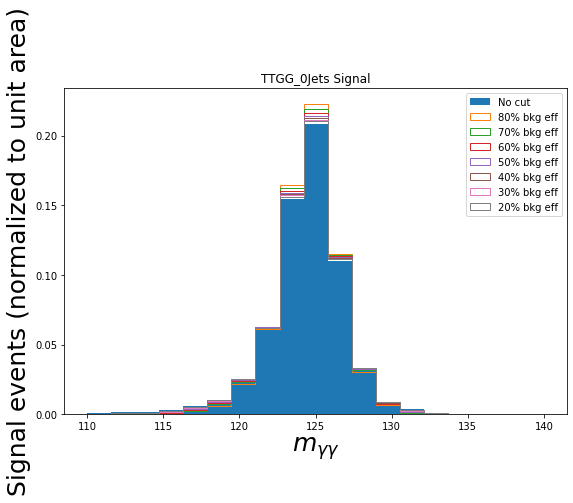

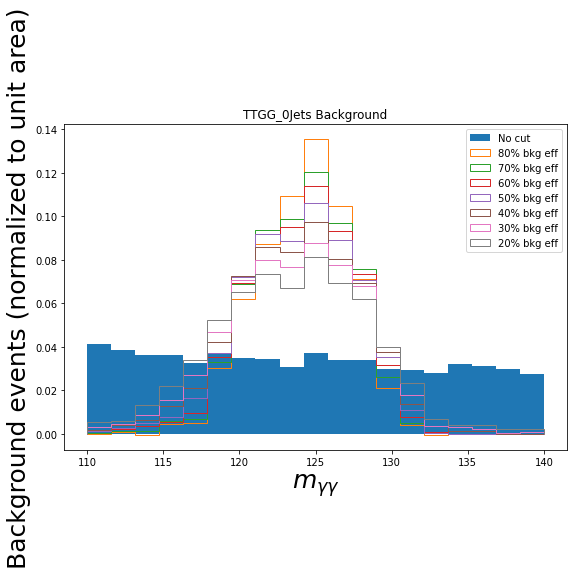

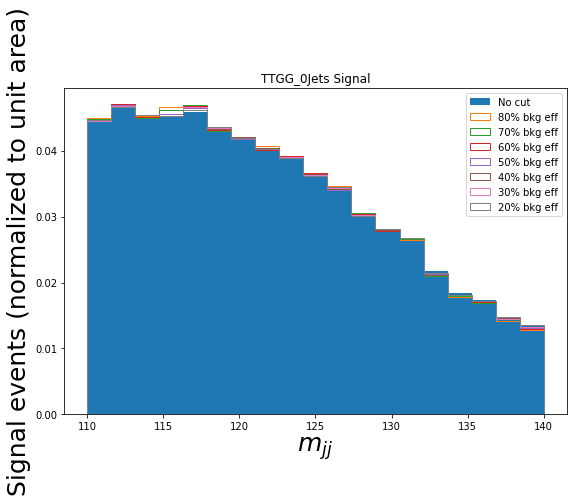

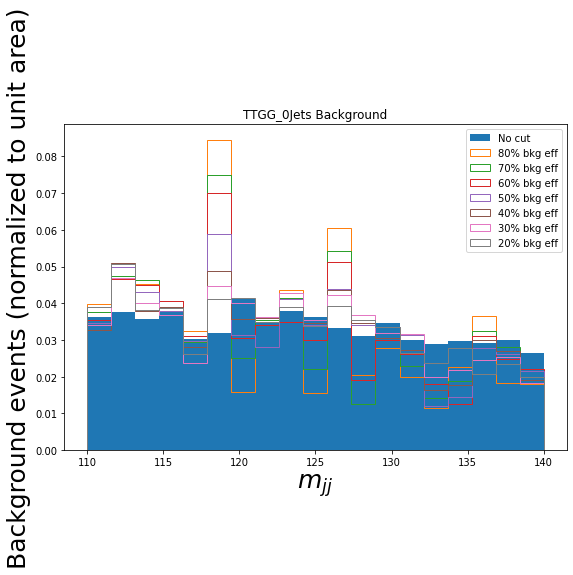

In [63]:
label_test = np.array([y_test]).T
test_all = np.concatenate((x_all_test,y_pred2, label_test), 1)
#signal
check_mass_gg(1, test_all, 20, 18, 22, 23, i)
#bkg
check_mass_gg(0, test_all, 20, 18, 22, 23, i)

#signal
check_mass_jj(1, test_all, 19, 18, 22, 23, i)
#bkg
check_mass_jj(0, test_all, 19, 18, 22, 23, i)

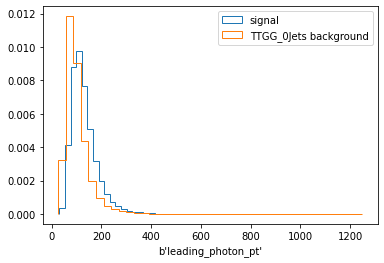

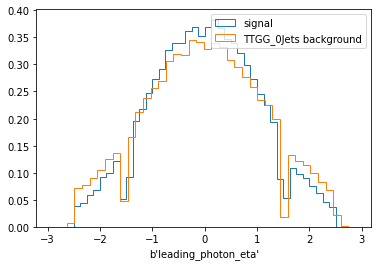

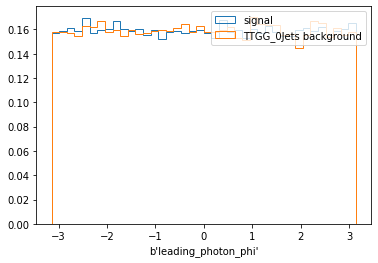

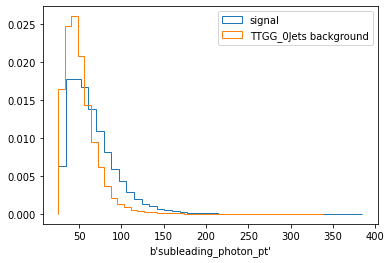

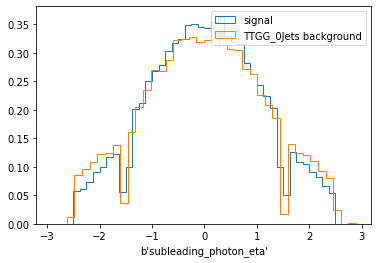

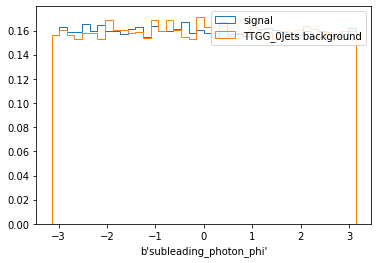

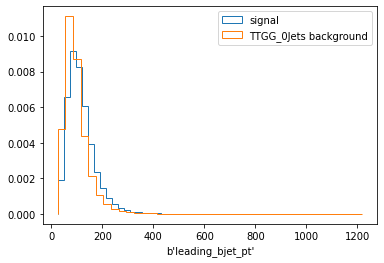

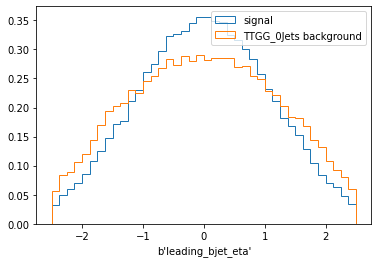

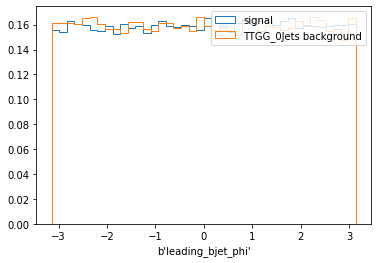

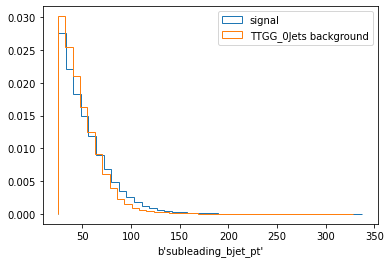

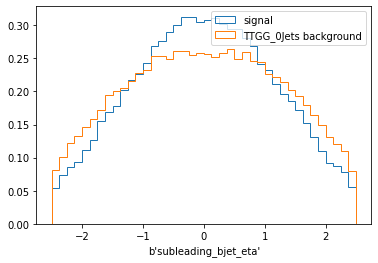

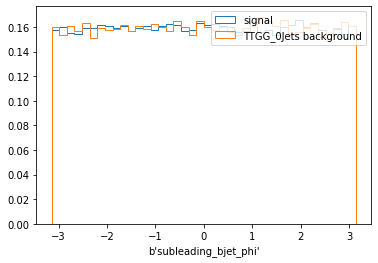

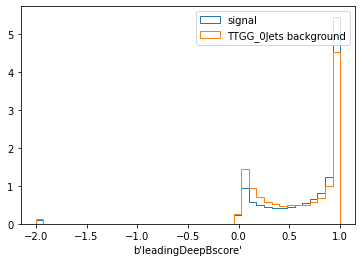

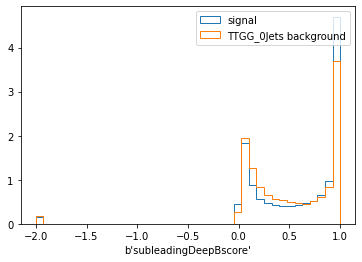

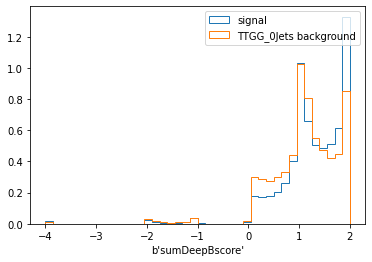

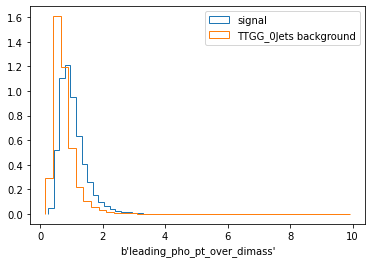

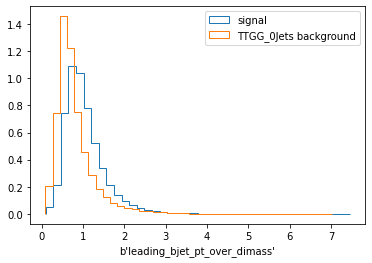

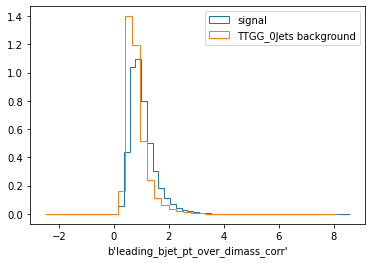

In [64]:
for hlf in training_vars:
    plt.figure()
    plt.hist(sig_df[hlf], bins=40, density=True, weights=sig_df[b'genweight'],
             histtype='step', label='signal')
    plt.hist(bkg_df[hlf], bins=40, density=True, weights=bkg_df[b'genweight'], 
             histtype='step', label= names[i] + ' background')
    plt.xlabel(hlf)
    plt.savefig(fname = f'BackgroundVsSignal_Plts/2018/{names[i]}_2018_{hlf}')
    plt.legend(loc='best')

# 